In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision, cv2
from torchvision import datasets, models, transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np
import time, os, math, glob, random

from PIL import Image

path = "/Users/pc/Desktop/polarization/"

In [2]:
# Build the Neural Network Model

channel_nums = 64
kernel_size  = 5

class Residual_Block(nn.Module):
    def __init__(self, channels, kernel_size):
        super(Residual_Block,self).__init__()
        self.conv1 = nn.Conv2d(in_channels  = channels, 
                               out_channels = channels, 
                               kernel_size  = kernel_size, 
                               padding      = kernel_size // 2, 
                               bias         = True)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels  = channels, 
                               out_channels = channels, 
                               kernel_size  = kernel_size, 
                               padding      = kernel_size // 2, 
                               bias         = True)
        
    def forward(self,x):
        residual = x
        out =  self.conv1(x)
        out =  self.relu(out)
        out =  self.conv2(out)
        out += residual
        return out
    
class Net_simple(nn.Module):
    def __init__(self,CHANNEL):
        super(Net_simple, self).__init__()
        
        self.conv_HSI_input = nn.Conv2d(CHANNEL + 1, 
                                        channel_nums, 
                                        kernel_size, 
                                        padding = kernel_size // 2)
        layers = []
        for i in range(10):
            layers += [Residual_Block(channel_nums, kernel_size)]
        self.layers = torch.nn.Sequential(*layers)
        
        self.conv_HSI_output = nn.Conv2d(channel_nums, 
                                         CHANNEL, 
                                         kernel_size, 
                                         padding = kernel_size // 2)
            
    def forward(self, coded_patch):
        
        x = self.conv_HSI_input(coded_patch)
        x = self.layers(x)
        output = self.conv_HSI_output(x)
        return output
    

In [3]:
# Neural Network Hyper Parameters
# Image Attribute
BATCH_SIZE = 8
IMAGE_SIZE = 128
CHANNEL    = 4

# Data Generator
NOISE_LEVEL_PRC      = 0.05
NOISE_LEVEL_codedmap = 0.05

# TV_weight = 1
L1_weight = 1
L2_weight = 1

In [4]:
# Device Set-up

device = torch.device("cpu")
net = Net_simple(CHANNEL)
net.to(device)
PATH = path + "Scripts/" + "ckpt.pth"
checkpoint = torch.load(PATH, map_location ='cpu')
checkpoint_new = {}
for k in checkpoint.keys():
    if not('total_ops' in k or 'total_params' in k):
        checkpoint_new[k] = checkpoint[k]
        
net.load_state_dict(checkpoint_new)

<All keys matched successfully>

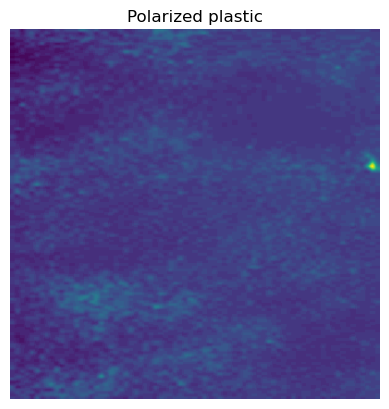

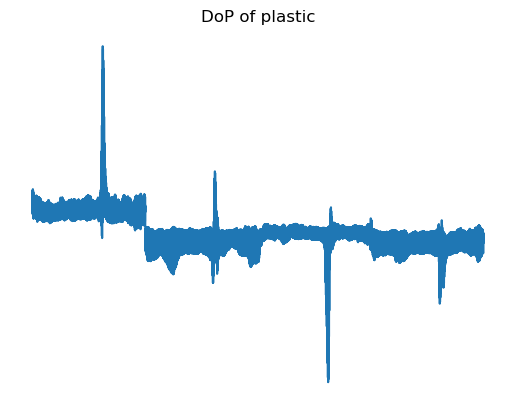

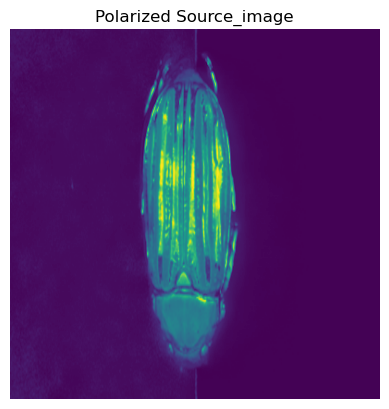

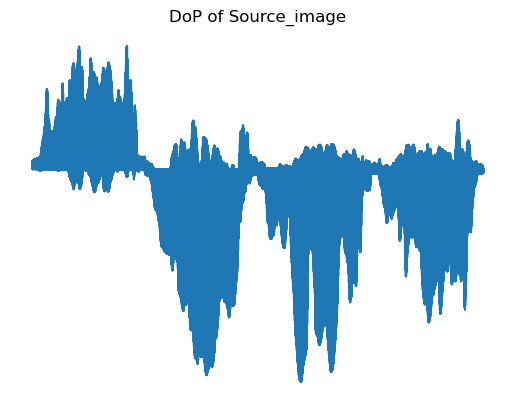

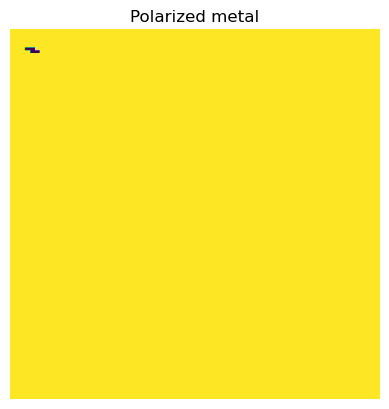

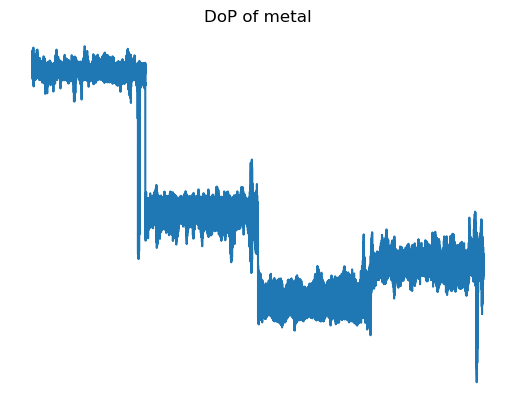

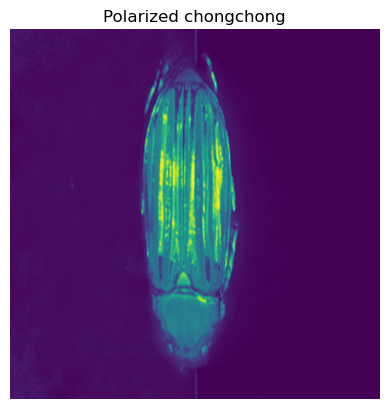

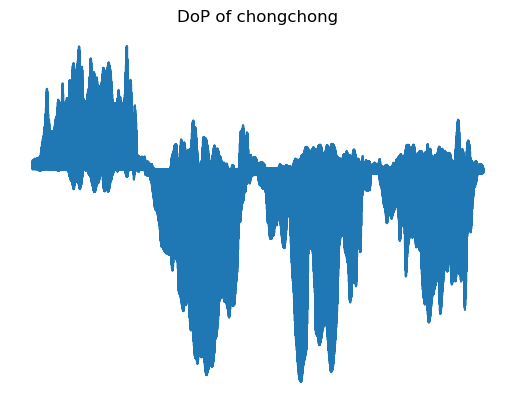

In [5]:
# Polarize the source image and the three material images

npy_list = ["plastic.npy", "Source_image.npy", "metal.npy", "chongchong.npy"]

for npy in npy_list:
    # ---------- Step 1. Prepare the image ----------
    
    # Load the Images
    npy_location = path + "dataset/" + npy
    coded_map = np.load(npy_location)
    
    # Convert the images to a 2D array by taking the first channel if it is a 3D array.
    if len(coded_map.shape) == 3:
        coded_map = coded_map[:, :, 0]
    
    # Resize the 2D array to a size of (400, 400) using bicubic interpolation.
    coded_map = np.array(Image.fromarray(coded_map).resize((400, 400)))
    
    # ---------- Step 2. Polarize the images using NN ----------
    
    # NN expects an input patch with an additional channel
    coded_map_show = coded_map * 1.0
    coded_map_show = coded_map_show[::-1]
    coded_map_new = coded_map.reshape(1, 400, 400)
    
    # Mask patch (mask_patch) loaded from "mueller.npy"
    mueller = np.load(path + "Scripts/" + "mueller.npy")
    mask_patch = mueller.transpose(2, 0, 1)
    
    # Concatenate the (mask_patch) and the (coded_map_new) 
    input_patch = np.concatenate([coded_map_new, mask_patch], 0)
    
    # Convert the input patch to a PyTorch tensor
    size = input_patch.shape
    input_patch_tensor = torch.tensor(np.reshape(input_patch, (1, size[0], size[1], size[2])))
    
    # Move it to the device (CPU)
    input_patch_tensor = input_patch_tensor.float().to(device)
    
    # Pass the input patch tensor through the NN to obtain the output tensor.
    output = net(input_patch_tensor)
    
    # Convert the output tensor back to a NumPy array and store it in the variable output.
    output = output.cpu().detach().numpy()[0]
    
    # ---------- Step 3. Plot the polarized images and DoP (degree of polarization) images ----------
    
    # Plot the polarized images
    plt.figure()
    plt.imshow(coded_map_show)
    plt.axis('off')
    plt.savefig(path + "Polarized Images/" + npy[:-4] + '_polarized.png', bbox_inches = 'tight', pad_inches = 0)
    plt.title("Polarized " + npy[:-4])
    
    # Plot the DoP images
    output_size = np.size(output)
    x = np.linspace(0, 1, output_size)
    material = np.reshape(output, (1, output_size))[0]
    
    plt.figure()
    plt.plot(x, material)
    plt.axis('off')
    plt.title("DoP of " + npy[:-4])
    plt.savefig(path + "Polarized Images/" + npy[:-4] + '_DoP.png', bbox_inches = 'tight', pad_inches = 0)
    plt.show()